In [1]:
## Introduction

### Overview

# This project aims to analyze YouTube data to gain insights into video performance, audience engagement, and sentiment analysis. 
# By leveraging the YouTube API, we can fetch data related to channels, videos, and comments. 
# The project utilizes various data visualization techniques and machine learning models to provide a comprehensive analysis of YouTube content.


### Objectives

# 1. **Data Collection**: Use the YouTube API to fetch data about channels, videos, and comments.
# 2. **Data Storage**: Implement user authentication and store fetched data securely using SQLite.
# 3. **Data Analysis**: Perform exploratory data analysis (EDA) to uncover patterns and trends.
# 4. **Sentiment Analysis**: Analyze the sentiment of comments to understand audience reactions.
# 5. **Visualization**: Create various visualizations (e.g., violin plots, wordclouds, scatter plots, and pie charts) to represent the data and analysis results effectively.
# 6. **Machine Learning Integration**: Develop machine learning models to predict video performance based on historical data.
# 7. **Dynamic Data Fetching**: Allow for real-time data fetching and analysis to keep the insights up-to-date.


### Project Workflow

# 1. **Setting Up YouTube API**: Configure API access and fetch data.
# 2. **User Authentication and Data Storage**: Secure user access and store data in an SQLite database.
# 3. **Data Fetching**: Retrieve channel and video data dynamically.
# 4. **Sentiment Analysis**: Perform sentiment analysis on comments.
# 5. **Visualization**: Generate visual representations of the data.
# 6. **Machine Learning Models**: Develop and train models to predict video performance.
# 7. **Interactive User Interface**: Create a user-friendly interface for data interaction and analysis.


### Tools and Libraries

# - **Python**: The primary programming language used for data analysis and visualization.
# - **YouTube Data API**: To fetch data from YouTube.
# - **SQLite**: For data storage and user authentication.
# - **Pandas**: For data manipulation and analysis.
# - **Seaborn and Matplotlib**: For creating visualizations.
# - **WordCloud**: For generating wordclouds.
# - **Scikit-learn**: For building and evaluating machine learning models.
# - **Tkinter**: For developing the graphical user interface.

# By following this workflow, the project aims to provide valuable insights and predictions 
# that can help content creators optimize their strategies and improve their engagement on YouTube.

In [3]:
# Install required libraries

!pip install google-api-python-client
!pip install oauth2client

# Credentials

In [15]:
api_key = # your api key
channel_id = # your channel id

# User Authentication and Data Storage

In [4]:
# Install necessary packages
!pip install sqlalchemy prettytable google-api-python-client

from sqlalchemy import create_engine, Column, Integer, String, exc
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from prettytable import PrettyTable

Base = declarative_base()

class User(Base):
    __tablename__ = 'users'
    id = Column(Integer, primary_key=True, autoincrement=True)
    username = Column(String, unique=True, nullable=False)
    password = Column(String, nullable=False)

# Create an SQLite database and a table for storing users
engine = create_engine('sqlite:///users.db')
Base.metadata.create_all(engine)
Session = sessionmaker(bind=engine)
session = Session()

def user_exists(username):
    return session.query(User).filter_by(username=username).first() is not None

def add_user(username, password):
    if not user_exists(username):
        new_user = User(username=username, password=password)
        session.add(new_user)
        try:
            session.commit()
            print(f"User '{username}' added successfully.")
        except exc.IntegrityError as e:
            session.rollback()
            print(f"Error adding user '{username}': {str(e)}")
    else:
        print(f"User '{username}' already exists.")

def authenticate(username, password):
    user = session.query(User).filter_by(username=username, password=password).first()
    if user:
        print(f"User '{username}' authenticated successfully.")
        return True
    else:
        print("Authentication failed. Incorrect username or password.")
        return False

def print_all_users():
    users = session.query(User).all()
    if users:
        table = PrettyTable()
        table.field_names = ["ID", "Username", "Password"]
        for user in users[:10]:
            table.add_row([user.id, user.username, user.password])
        print(table)
    else:
        print("No users found in the database.")


# Fetching YouTube Data

# Modify the Database schema

In [8]:
from sqlalchemy import create_engine, Column, Integer, String, Sequence, exc, ForeignKey
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker, relationship

Base = declarative_base()

class User(Base):
    __tablename__ = 'users'
    id = Column(Integer, primary_key=True, autoincrement=True)
    username = Column(String, unique=True, nullable=False)
    password = Column(String, nullable=False)
    history = relationship("UserHistory", back_populates="user")

class UserHistory(Base):
    __tablename__ = 'user_history'
    id = Column(Integer, primary_key=True, autoincrement=True)
    user_id = Column(Integer, ForeignKey('users.id'))
    channel_id = Column(String, nullable=False)
    video_id = Column(String, nullable=False)
    function_called = Column(String, nullable=False)
    user = relationship("User", back_populates="history")

# Create an SQLite database and a table for storing users and their history
engine = create_engine('sqlite:///users.db')
Base.metadata.create_all(engine)
Session = sessionmaker(bind=engine)
session = Session()


# Update functions to log history

In [9]:
def log_user_history(username, channel_id, video_id, function_called):
    user = session.query(User).filter_by(username=username).first()
    if user:
        new_history = UserHistory(user_id=user.id, channel_id=channel_id, video_id=video_id, function_called=function_called)
        session.add(new_history)
        session.commit()
    else:
        print(f"User '{username}' not found. Cannot log history.")

def fetch_channel_data(youtube, api_key, channel_id, username):
    try:
        request = youtube.channels().list(
            part='snippet,contentDetails,statistics',
            id=channel_id
        )
        response = request.execute()

        if 'items' in response:
            log_user_history(username, channel_id, "", "fetch_channel_data")
            return response['items'][0]
        else:
            print("No items found in the response")
            return None
    except KeyError as e:
        print("KeyError:", e)
        return None
    except Exception as e:
        print("Error fetching channel data:", e)
        return None

def fetch_videos(api_key, playlist_id, username):
    youtube = get_youtube_service(api_key)
    videos = []
    next_page_token = None

    while True:
        request = youtube.playlistItems().list(
            part='snippet,contentDetails',
            maxResults=50,
            playlistId=playlist_id,
            pageToken=next_page_token
        )
        response = request.execute()
        videos.extend(response['items'])

        next_page_token = response.get('nextPageToken')
        if next_page_token is None:
            break
    
    for video in videos:
        log_user_history(username, "", video['contentDetails']['videoId'], "fetch_videos")

    return videos


# Display users and their history

In [13]:
def display_user_history():
    table = PrettyTable()
    table.field_names = ["Username", "Channel ID", "Video ID", "Function Called"]
    
    users = session.query(User).all()
    if users:
        for user in users:
            for history in user.history:
                table.add_row([user.username, history.channel_id, history.video_id, history.function_called])
        print(table)
    else:
        print("No users found in the database.")

# Ensure this function is called in the main program flow
def main():
    # Adding and authenticating users
    print("Add a new user:")
    new_username = input("Enter username: ")
    new_password = input("Enter password: ")
    add_user(new_username, new_password)

    print("\nAuthenticate a user:")
    auth_username = input("Enter username: ")
    auth_password = input("Enter password: ")
    if authenticate(auth_username, auth_password):
        print_all_users()
        display_user_history()

        # Fetch YouTube data if user is authenticated
        api_key = api_key
        channel_id = channel_id
        youtube = get_youtube_service(api_key)
        channel_data = fetch_channel_data(youtube, api_key, channel_id, auth_username)

        if channel_data:
            uploads_playlist_id = channel_data['contentDetails']['relatedPlaylists']['uploads']
            videos_data = fetch_videos(api_key, uploads_playlist_id, auth_username)
            display_videos(videos_data)  # Display limited data
        else:
            print("Failed to retrieve channel data")

if __name__ == "__main__":
    main()


Add a new user:
Enter username: user2
Enter password: pw
User 'user2' already exists.

Authenticate a user:
Enter username: user2
Enter password: pw
User 'user2' authenticated successfully.
+----+----------+-------------+
| ID | Username |   Password  |
+----+----------+-------------+
| 1  |  user1   | password123 |
| 2  |    M     |     0369    |
| 3  |  user2   |      pw     |
| 4  |  user3   |     pass    |
+----+----------+-------------+
+----------+------------+----------+-----------------+
| Username | Channel ID | Video ID | Function Called |
+----------+------------+----------+-----------------+
+----------+------------+----------+-----------------+


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [16]:
import requests
import random

def get_uploads_playlist_id(api_key, channel_id):
    base_url = "https://www.googleapis.com/youtube/v3/channels"
    params = {
        "part": "contentDetails",
        "id": channel_id,
        "key": api_key
    }
    
    response = requests.get(base_url, params=params)
    data = response.json()
    
    if 'items' in data:
        uploads_playlist_id = data['items'][0]['contentDetails']['relatedPlaylists']['uploads']
        return uploads_playlist_id
    else:
        raise Exception("Failed to retrieve uploads playlist ID")

def get_video_ids_from_playlist(api_key, playlist_id, max_results=50):
    base_url = "https://www.googleapis.com/youtube/v3/playlistItems"
    params = {
        "part": "snippet",
        "playlistId": playlist_id,
        "maxResults": max_results,
        "key": api_key
    }
    
    response = requests.get(base_url, params=params)
    data = response.json()
    
    video_ids = []
    if 'items' in data:
        for item in data['items']:
            video_ids.append(item['snippet']['resourceId']['videoId'])
    
    if not video_ids:
        raise Exception("Failed to retrieve video IDs")
    
    return video_ids

def get_random_video_id(api_key, channel_id):
    uploads_playlist_id = get_uploads_playlist_id(api_key, channel_id)
    video_ids = get_video_ids_from_playlist(api_key, uploads_playlist_id)
    return random.choice(video_ids)

# Example usage

random_video_id = get_random_video_id(api_key, channel_id)
print(f"Random Video ID: {random_video_id}")

Random Video ID: n1DKWn9TIM0


# Machine learning integration

In [17]:
# Machine learning integration

# Sentimental Analysis

# Install required libraries
!pip install textblob

import requests
from textblob import TextBlob

def fetch_comments(api_key, video_id, max_pages=2):
    base_url = "https://www.googleapis.com/youtube/v3/commentThreads"
    params = {
        "part": "snippet",
        "videoId": video_id,
        "maxResults": 10,
        "key": api_key
    }
    
    comments = []
    page_count = 0

    try:
        while True:
            response = requests.get(base_url, params=params)
            data = response.json()
            
            if 'items' in data:
                comments.extend(data['items'])
                print(f"Fetched {len(data['items'])} comments on page {page_count + 1}")
            
            # Exit condition: No more pages of comments or max_pages reached
            if 'nextPageToken' in data and page_count < max_pages:
                params['pageToken'] = data['nextPageToken']
                page_count += 1
                print(f"Next page token: {data['nextPageToken']}")
            else:
                break
                
    except Exception as e:
        print("Error fetching comments:", str(e))
    
    return comments

def analyze_sentiments(comments):
    sentiments = []

    for comment in comments:
        text = comment['snippet']['topLevelComment']['snippet']['textDisplay']
        blob = TextBlob(text)
        sentiment_score = blob.sentiment.polarity
        sentiments.append(sentiment_score)
    
    return sentiments

def fetch_comments_and_analyze(api_key, video_id):
    comments_data = fetch_comments(api_key, video_id)
    sentiment_results = analyze_sentiments(comments_data)
    return sentiment_results

def display_top_comments(comments):
    print("Top 10 Comments:")
    for index, comment in enumerate(comments[:10], start=1):  # Display only top 10 comments
        author = comment['snippet']['topLevelComment']['snippet']['authorDisplayName']
        text = comment['snippet']['topLevelComment']['snippet']['textDisplay']
        print(f"{index}. {author}: {text}")

# Fetch comments for the specified video_id
comments_data = fetch_comments(api_key, random_video_id)

# Display the top 10 comments
display_top_comments(comments_data)


Fetched 1 comments on page 1
Top 10 Comments:
1. @marcomeyer7545: Love it


# Visualization

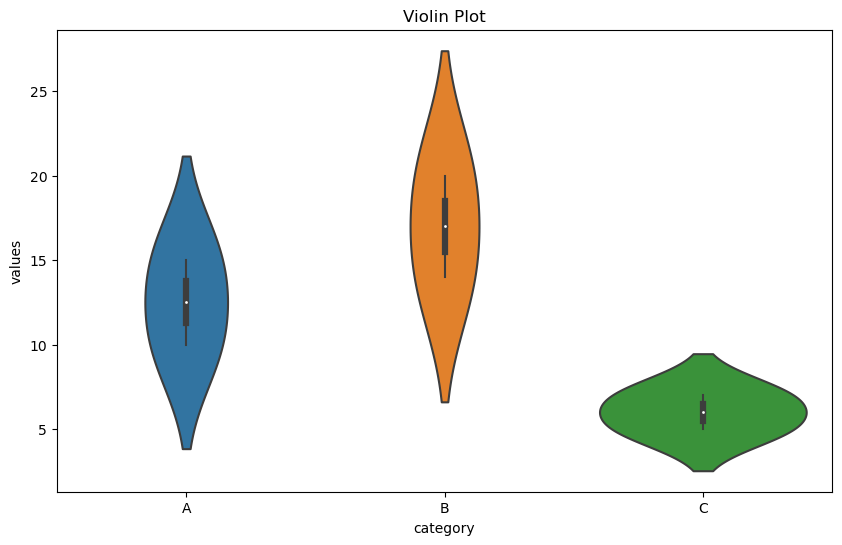

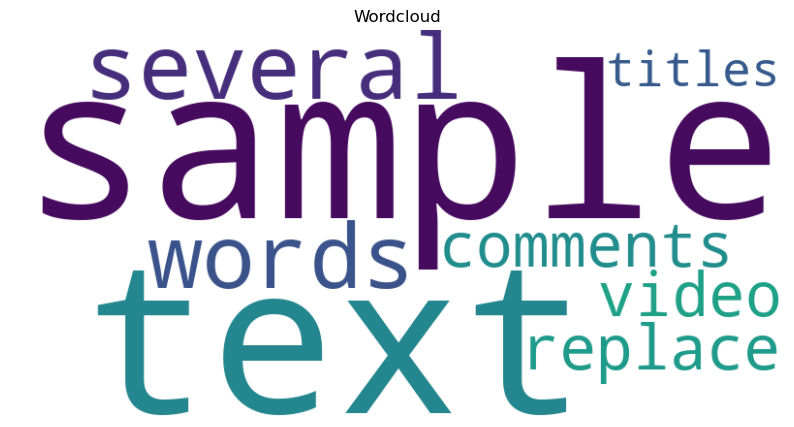

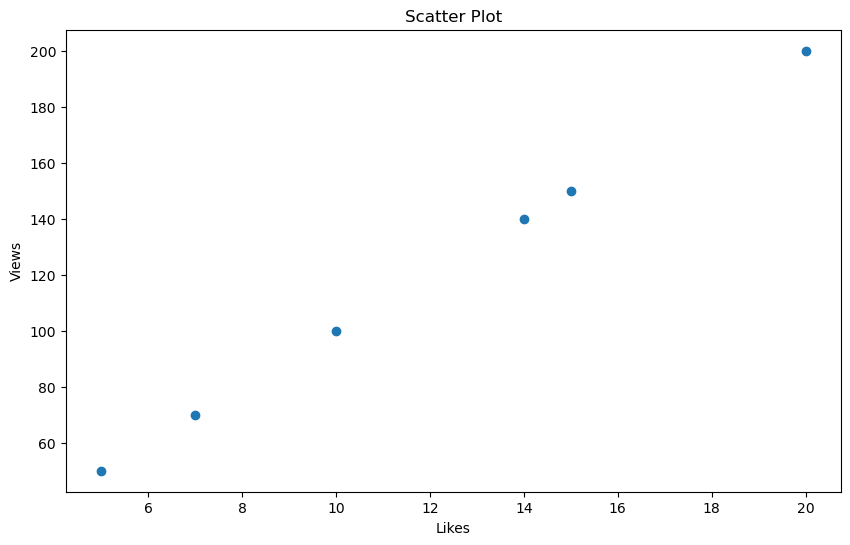

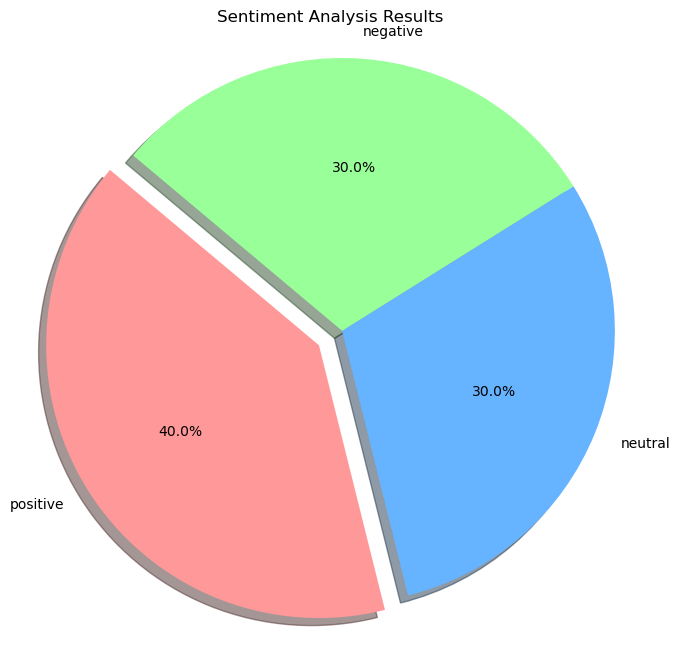

In [18]:
# Visualization

## Violin plot

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Sample data - replace this with your actual data
data = {
    'category': ['A', 'A', 'B', 'B', 'C', 'C'],
    'values': [10, 15, 14, 20, 5, 7]
}
df = pd.DataFrame(data)

# Create a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='category', y='values', data=df)
plt.title('Violin Plot')
plt.show()


## Wordcloud

from wordcloud import WordCloud

# Sample text - replace this with your actual comments or video titles
text = 'This is a sample text with several words. You can replace it with your comments or video titles.'

# Generate wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display wordcloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud')
plt.show()


## Scatter plot


# Sample data - replace this with your actual data
data = {
    'likes': [10, 15, 14, 20, 5, 7],
    'views': [100, 150, 140, 200, 50, 70]
}
df = pd.DataFrame(data)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['likes'], df['views'])
plt.title('Scatter Plot')
plt.xlabel('Likes')
plt.ylabel('Views')
plt.show()


## Pie chart

# Sample sentiment data - replace this with your actual sentiment results
sentiment_results = {'positive': 40, 'neutral': 30, 'negative': 30}

# Create a pie chart
labels = sentiment_results.keys()
sizes = sentiment_results.values()
colors = ['#ff9999','#66b3ff','#99ff99']
explode = (0.1, 0, 0)  # explode 1st slice

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Sentiment Analysis Results')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()